# debug_zmd_registration
In this notebook I want to visually check the various steps in the registration that happened when I ran Zahra's spim_register.py file to do the cell -> reg and reg-> atlas registration on Chris Zimmerman's 3.6x SmartSPIM brain.

# General imports

In [1]:
import os,sys, glob, shutil, pickle
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import SimpleITK as sitk
%matplotlib inline

In [13]:
sys.path.append('/jukebox/wang/ahoag/ClearMap2') 
import ClearMap.IO.Workspace as wsp
import ClearMap.IO.IO as io
import ClearMap.ParallelProcessing.BlockProcessing as bp
import ClearMap.ImageProcessing.Experts.Cells as cells
import ClearMap.Settings as settings
import ClearMap.Alignment.Resampling as res
import ClearMap.Alignment.Elastix as elx   
import ClearMap.Alignment.Annotation as ano

Elastix sucessfully initialized from path: /jukebox/wang/ahoag/ClearMap2/ClearMap/External/elastix/build


In [14]:
data_dir = '/jukebox/LightSheetData/lightserv/cz15/zimmerman_01/zimmerman_01-001/imaging_request_1/rawdata/resolution_3.6x'
elastix_dir = os.path.join(data_dir,'elastix')
elastix_inverse_dir = os.path.join(data_dir,'elastix_inverse_transform')
ch488_dir = os.path.join(data_dir,'Ex_488_Em_0')
ch642_dir = os.path.join(data_dir,'Ex_642_Em_2')

In [30]:
ch488_downsized_file = os.path.join(ch488_dir,'downsized_for_atlas.tif')
ch488_downsized_vol = tifffile.imread(ch488_downsized_file)

In [31]:
ch642_downsized_file = os.path.join(ch642_dir,'downsized_for_atlas.tif')
ch642_downsized_vol = tifffile.imread(ch642_downsized_file)

In [32]:
ch488_downsized_vol.shape

(638, 739, 448)

In [33]:
ch642_downsized_vol.shape

(638, 739, 448)

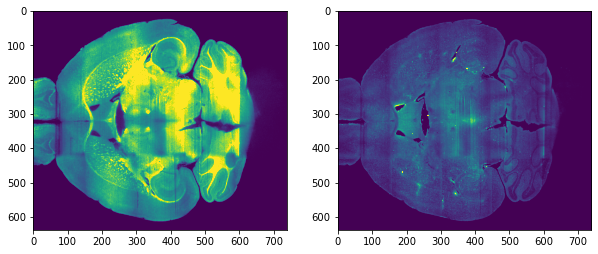

In [34]:
# Compare 488 and 642
fig=plt.figure(figsize=(10,8))
ax_488=fig.add_subplot(121)
z_plane_488 = ch488_downsized_vol[:,:,200]
ax_488.imshow(z_plane_488,vmin=0,vmax=500)
ax_642=fig.add_subplot(122)
z_plane_642 = ch642_downsized_vol[:,:,200]
ax_642.imshow(z_plane_642,vmin=0,vmax=200)

They look nicely aligned already. Now let's check after cell -> auto alignment

In [35]:
ch642_reg_to_488_file = os.path.join(elastix_dir,'Ex_642_Em_2_to_Ex_488_Em_0','result.1.tif')
ch642_reg_to_488_vol = tifffile.imread(ch642_reg_to_488_file)

In [21]:
ch642_reg_to_488_vol.shape

(638, 739, 448)

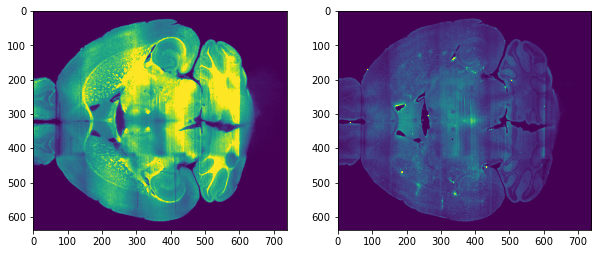

In [36]:
# Compare 488 and 642 registered to 488
fig=plt.figure(figsize=(10,8))
ax_488=fig.add_subplot(121)
z_plane_488 = ch488_downsized_vol[:,:,200]
ax_488.imshow(z_plane_488,vmin=0,vmax=500)
ax_642=fig.add_subplot(122)
z_plane_642 = ch642_reg_to_488_vol[:,:,200]
ax_642.imshow(z_plane_642,vmin=0,vmax=200)

Looks good! Now check reg -> atlas

In [37]:
ch488_reg_to_atlas_file = os.path.join(elastix_dir,'result.1.tif')
ch488_reg_to_atlas_vol = tifffile.imread(ch488_reg_to_atlas_file)

In [38]:
ch488_reg_to_atlas_vol.shape

(540, 640, 352)

In [39]:
pma_file = '/jukebox/LightSheetTransfer/atlas/sagittal_atlas_20um_iso.tif'
pma_vol = tifffile.imread(pma_file)

In [40]:
pma_vol.shape

(540, 640, 352)

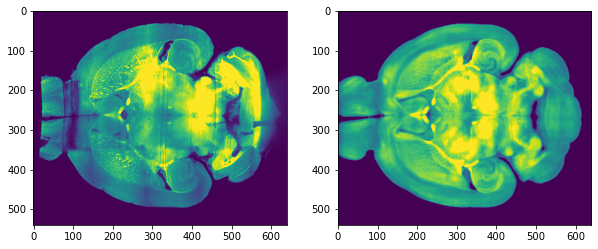

In [41]:
# Compare 488 reg to atlas with atlas
fig=plt.figure(figsize=(10,8))
ax_488=fig.add_subplot(121)
z_plane_488 = ch488_reg_to_atlas_vol[:,:,200]
ax_488.imshow(z_plane_488,vmin=0,vmax=500)
ax_atlas=fig.add_subplot(122)
z_plane_atlas = pma_vol[:,:,200]
ax_atlas.imshow(z_plane_atlas,vmin=0,vmax=200)

Looks good! So we should be able to use the inverse transforms to scale the raw cells to reg space. I verified that I can scale the atlas back to raw space with these transforms so we know they work!

## Set up the workspace

In [42]:
directory = os.path.join('/jukebox/wang/ahoag/test_clearmap2/output',
             'cz15/zimmerman_01_smartspim/zimmerman_01-001',
             'imaging_request_1/output')

expression_raw      = 'ch647_renamed/corrected/Z<Z,4>.tif'    
expression_auto     = 'ch488_renamed/corrected/Z<Z,4>.tif'

ws = wsp.Workspace('CellMap', directory=directory);
ws.update(raw=expression_raw)
ws.update(autofluorescence=expression_auto)
resources_directory = settings.resources_path
ws.debug=False
ws.info()

Workspace[CellMap]{/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output}
              raw: ch647_renamed/corrected/Z<Z,4>.tif {3589 files, ('Z',): (0,) -> (3588,)}
 autofluorescence: ch488_renamed/corrected/Z<Z,4>.tif {3586 files, ('Z',): (0,) -> (3585,)}
         stitched: stitched.npy
           layout: no file
       background: no file
        resampled: resampled.tif
                   resampled_autofluorescence.tif
resampled_to_auto: no file
auto_to_reference: no file
            cells: cells_raw.npy
                   cells_transformed_to_atlas.npy
                   cells_transformed_to_atlas_attempt1.npy
                   cells_transformed_to_atlas_attempt2.npy
                   cells_transformed_to_atlas_attempt3.npy
          density: no file



## Align raw cells to atlas

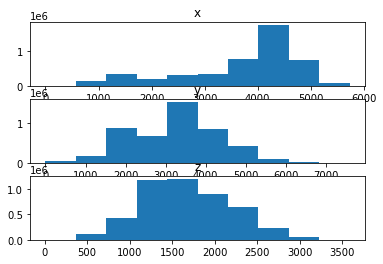

In [43]:
# Check distributions of x,y,z in raw cells
source = ws.source('cells', postfix='raw')
nx=3
ny=1
for i, name in enumerate(["x","y","z"]):
    plt.subplot(nx, ny, i+1)
    plt.hist(source[name]);
    plt.title(name)

In [44]:
source = ws.source('cells', postfix='raw')
coordinates_raw = np.hstack([source[c][:,None] for c in 'xyz']) 

In [76]:
coordinates_raw

array([[3593, 4549,   10],
       [1974,   70,   60],
       [2600, 3406,   89],
       ...,
       [1629, 2274, 3588],
       [1639, 2286, 3588],
       [2310, 5892, 3588]])

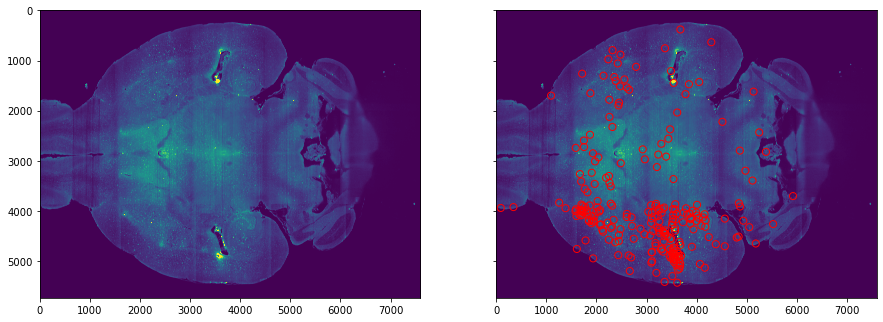

In [52]:
# Verify that raw cells are in the right locations and we understand the x,y,z layout of these clearmap files
z=2000
this_plane_coords = np.array([coord for coord in coordinates_raw if coord[-1] == z])
xs = this_plane_coords[:,0]
ys = this_plane_coords[:,1]
fig,axes = plt.subplots(figsize=(15,8),nrows=1,ncols=2,sharex=True,sharey=True)
ax_tissue = axes[0]
stitched_z_plane = ws.source('stitched')[:,:,z] 
ax_tissue.imshow(stitched_z_plane,vmin=0,vmax=200,cmap='viridis')
ax_both=axes[1]
ax_both.imshow(stitched_z_plane,vmin=0,vmax=200,cmap='viridis')
ax_both.scatter(ys[::10],xs[::10],s=50,facecolors='none',edgecolors='r')
plt.show()

OK that looks good. Can see that cells are clearly circled. Raw volume is "horizontally" oriented, i.e. z planes are horizontal cuts

Now let's verify that the alignment steps worked

In [29]:
io.shape(ch488_downsized_file) # xyz format

(448, 739, 638)

In [16]:
io.shape(ws.filename('stitched')) #  xyz format

(5734, 7592, 3589)

The first thing that Zahra does in the downsizing is swap the x and z axes. So we need to do that for the cell coordinates before we resample them. 

In [59]:
coordinates_raw

array([[3593, 4549,   10],
       [1974,   70,   60],
       [2600, 3406,   89],
       ...,
       [1629, 2274, 3588],
       [1639, 2286, 3588],
       [2310, 5892, 3588]])

In [58]:
coordinates_raw[:,0]

array([3593, 1974, 2600, ..., 1629, 1639, 2310])

In [60]:
coordinates_raw_swapped_axes = np.zeros_like(coordinates_raw)
coordinates_raw_swapped_axes[:,0] = coordinates_raw[:,2]
coordinates_raw_swapped_axes[:,1] = coordinates_raw[:,1]
coordinates_raw_swapped_axes[:,2] = coordinates_raw[:,0]

In [61]:
coordinates_raw_swapped_axes

array([[  10, 4549, 3593],
       [  60,   70, 1974],
       [  89, 3406, 2600],
       ...,
       [3588, 2274, 1629],
       [3588, 2286, 1639],
       [3588, 5892, 2310]])

Next I need to downsize using a source shape where the x and z coordinates have been swapped

In [65]:
io.shape(ws.filename('stitched'))

(5734, 7592, 3589)

In [66]:
io.shape(ws.filename('stitched'))[::-1]

(3589, 7592, 5734)

In [67]:
io.shape(ch642_downsized_file)

(448, 739, 638)

In [68]:
# now these are in the right order

In [69]:
coordinates_resampled = res.resample_points(
                  coordinates_raw_swapped_axes, sink=None, orientation=None,
                  source_shape=io.shape(ws.filename('stitched'))[::-1],
                  sink_shape=io.shape(ch642_downsized_file));

Text(0.5, 0.98, 'Distribution of cell centers in resampled cells')

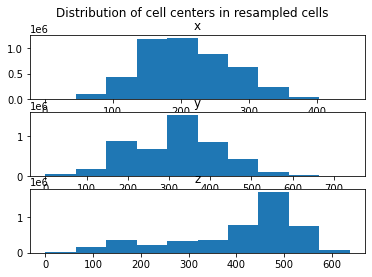

In [70]:
# Check resampled distributions
nx=3
ny=1
for i, name in enumerate(["x","y","z"]):
    plt.subplot(nx, ny, i+1)
    cellcoords = coordinates_resampled[:,i]
    plt.hist(cellcoords);
    plt.title(name)
plt.suptitle("Distribution of cell centers in resampled cells")

Orientation of cell volume now looks like x and z have been swapped, so they are in the right shape as the downsized volume that Zahra/Annie made. Now the z planes are sagittal cuts. Let's take a look at the horizontal planes to make sure they are still correct.

In [71]:
coordinates_resampled

array([[  1.24825857, 442.79649631, 399.77921172],
       [  7.48955141,   6.81375132, 219.63934426],
       [ 11.10950125, 331.53767123, 289.2919428 ],
       ...,
       [447.87517414, 221.3495785 , 181.25252878],
       [447.87517414, 222.51765016, 182.36519009],
       [447.87517414, 573.5231823 , 257.02476456]])

In [72]:
x=250
this_plane_coords_resampled = np.array([coord for coord in coordinates_resampled if int(coord[0]) == x])
ys = this_plane_coords_resampled[:,1]
zs = this_plane_coords_resampled[:,2]

In [73]:
this_plane_coords_resampled

array([[250.02619114, 373.29623288,  45.17404953],
       [250.02619114, 414.37341939,  46.95430764],
       [250.02619114, 391.40134352,  47.84443669],
       ...,
       [250.89997214, 260.38263962, 630.21137077],
       [250.89997214,  56.16477871, 632.99302407],
       [250.89997214, 504.41227608, 636.77607255]])

In [56]:
ch642_downsized_vol.shape

(638, 739, 448)

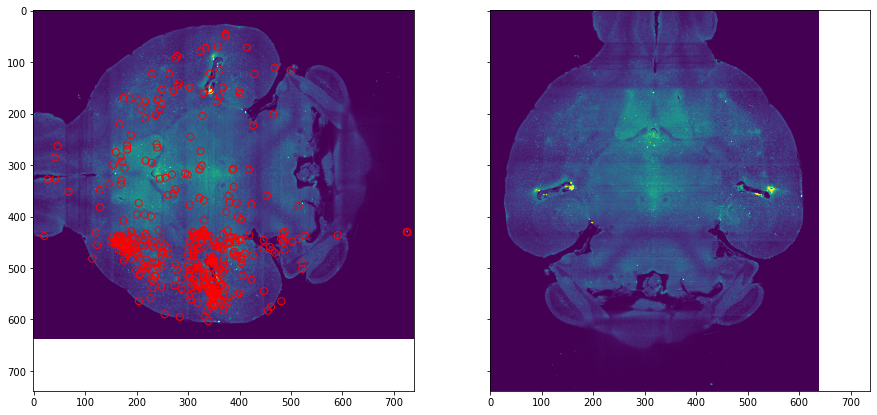

In [84]:
# Verify that raw cells are in the right locations and we understand the x,y,z layout of these clearmap files
fig,axes = plt.subplots(figsize=(15,8),nrows=1,ncols=2,sharex=True,sharey=True)
ax_tissue = axes[0]
resampled_z_plane = ch642_downsized_vol[:,:,x]
# resampled_z_plane_fixaxes = np.swapaxes(resampled_z_plane,0,1)
ax_tissue.imshow(resampled_z_plane,vmin=0,vmax=200,cmap='viridis')
ax_both=axes[1]
ax_both.imshow(resampled_z_plane_fixaxes,vmin=0,vmax=200,cmap='viridis')
ax_tissue.scatter(ys[::50],zs[::50],s=50,facecolors='none',edgecolors='r')


Still looks aligned and has overall general pattern to raw space.

In [85]:
coordinates_aligned_to_488 = elx.transform_points(
                  coordinates_resampled, sink=None,
                  transform_directory=os.path.join(elastix_inverse_dir,'Ex_488_Em_0_to_Ex_642_Em_2'),
                  binary=True, indices=False);

/jukebox/wang/ahoag/ClearMap2/ClearMap/External/elastix/build/bin/transformix -def /tmp/elastix_input.bin -out /tmp/elastix_output -tp /jukebox/LightSheetData/lightserv/cz15/zimmerman_01/zimmerman_01-001/imaging_request_1/rawdata/resolution_3.6x/elastix_inverse_transform/Ex_488_Em_0_to_Ex_642_Em_2/TransformParameters.1.txt


Text(0.5, 0.98, 'Distribution of cell centers in 642 aligned to 488 space')

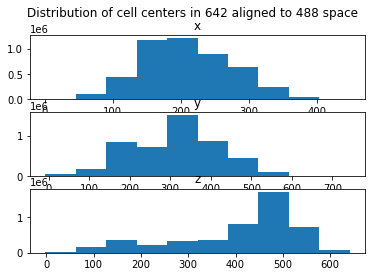

In [86]:
# Check new distributions
nx=3
ny=1
for i, name in enumerate(["x","y","z"]):
    plt.subplot(nx, ny, i+1)
    cellcoords = coordinates_aligned_to_488[:,i]
    plt.hist(cellcoords);
    plt.title(name)
plt.suptitle("Distribution of cell centers in 642 aligned to 488 space")

In [87]:
x=250
this_plane_coords_aligned_to_488 = np.array([coord for coord in coordinates_aligned_to_488 if int(coord[0]) == x])
ys = this_plane_coords_aligned_to_488[:,1]
zs = this_plane_coords_aligned_to_488[:,2]

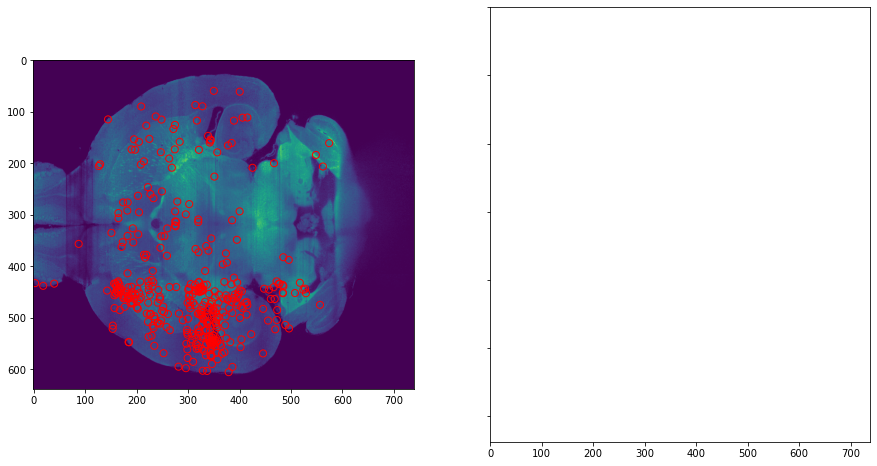

In [89]:
# Verify that raw cells are in the right locations and we understand the x,y,z layout of these clearmap files
fig,axes = plt.subplots(figsize=(15,8),nrows=1,ncols=2,sharex=True,sharey=True)
ax_tissue = axes[0]
resampled_z_plane = ch488_downsized_vol[:,:,x]
# resampled_z_plane_fixaxes = np.swapaxes(resampled_z_plane,0,1)
ax_tissue.imshow(resampled_z_plane,vmin=0,vmax=1000,cmap='viridis')
# ax_both=axes[1]
# ax_both.imshow(resampled_z_plane_fixaxes,vmin=0,vmax=200,cmap='viridis')
ax_tissue.scatter(ys[::50],zs[::50],s=50,facecolors='none',edgecolors='r')


Still looks good. Now do final transformation to atlas.

In [90]:
coordinates_aligned_to_atlas = elx.transform_points(
                  coordinates_aligned_to_488, sink=None,
                  transform_directory=elastix_inverse_dir,
                  binary=True, indices=False);

/jukebox/wang/ahoag/ClearMap2/ClearMap/External/elastix/build/bin/transformix -def /tmp/elastix_input.bin -out /tmp/elastix_output -tp /jukebox/LightSheetData/lightserv/cz15/zimmerman_01/zimmerman_01-001/imaging_request_1/rawdata/resolution_3.6x/elastix_inverse_transform/TransformParameters.1.txt


In [94]:
# Save the transformed cells
header = ['x','y','z'];
dtypes = [int, int, int];

dt = {'names' : header, 'formats' : dtypes};
cells_out = np.zeros(len(coordinates_aligned_to_atlas), dtype=dt);
for i,h in enumerate(header):
    cells_out[h] = coordinates_aligned_to_atlas[:,i];

In [95]:
cells_out

array([( -9, 413, 328), (  5,  20, 185), (  0, 310, 241), ...,
       (372, 214, 148), (372, 216, 149), (374, 533, 230)],
      dtype=[('x', '<i8'), ('y', '<i8'), ('z', '<i8')])

In [96]:
# save the array as an npy file
savename = ws.filename('cells',postfix='transformed_to_atlas')
io.write(savename,cells_out)

'/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/cells_transformed_to_atlas.npy'

Text(0.5, 0.98, 'Distribution of cell centers aligned to atlas space')

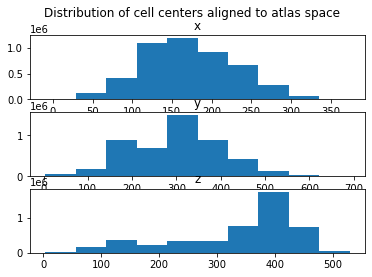

In [91]:
# Check new distributions
nx=3
ny=1
for i, name in enumerate(["x","y","z"]):
    plt.subplot(nx, ny, i+1)
    cellcoords = coordinates_aligned_to_atlas[:,i]
    plt.hist(cellcoords);
    plt.title(name)
plt.suptitle("Distribution of cell centers aligned to atlas space")

In [92]:
x=200
this_plane_coords_aligned_to_atlas = np.array([coord for coord in coordinates_aligned_to_atlas if int(coord[0]) == x])
ys = this_plane_coords_aligned_to_atlas[:,1]
zs = this_plane_coords_aligned_to_atlas[:,2]

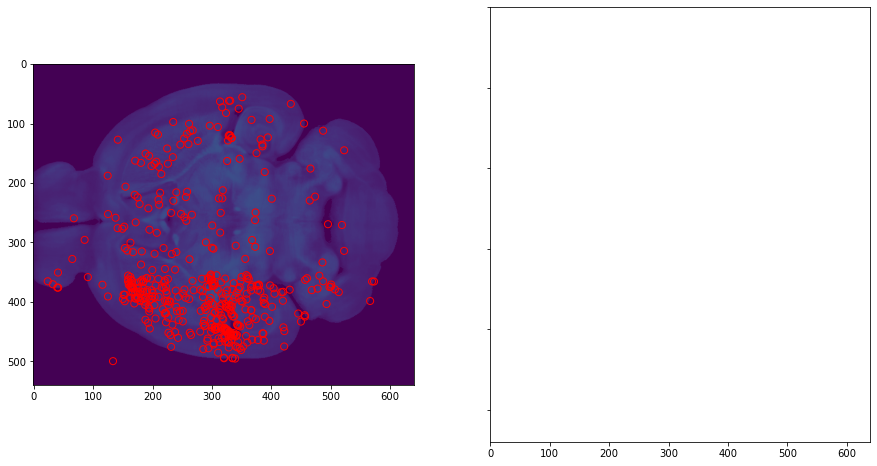

In [93]:
# Verify that raw cells are in the right locations and we understand the x,y,z layout of these clearmap files
fig,axes = plt.subplots(figsize=(15,8),nrows=1,ncols=2,sharex=True,sharey=True)
ax_tissue = axes[0]
resampled_z_plane = pma_vol[:,:,x]
# resampled_z_plane_fixaxes = np.swapaxes(resampled_z_plane,0,1)
ax_tissue.imshow(resampled_z_plane,vmin=0,vmax=1000,cmap='viridis')
# ax_both=axes[1]
# ax_both.imshow(resampled_z_plane_fixaxes,vmin=0,vmax=200,cmap='viridis')
ax_tissue.scatter(ys[::50],zs[::50],s=50,facecolors='none',edgecolors='r')

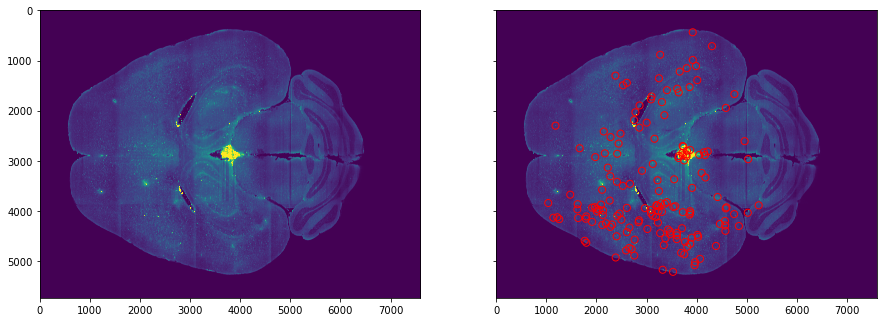

In [70]:
# Compare to raw data at a similar plane
z=2000
this_plane_coords_raw = np.array([coord for coord in coordinates_raw if coord[-1] == z])
xs_raw = this_plane_coords_raw[:,0]
ys_raw = this_plane_coords_raw[:,1]
fig,axes = plt.subplots(figsize=(15,8),nrows=1,ncols=2,sharex=True,sharey=True)
ax_tissue = axes[0]
stitched_z_plane = ws.source('stitched')[:,:,z] 
ax_tissue.imshow(stitched_z_plane,vmin=0,vmax=200,cmap='viridis')
ax_both=axes[1]
ax_both.imshow(stitched_z_plane,vmin=0,vmax=200,cmap='viridis')
ax_both.scatter(ys_raw[::10],xs_raw[::10],s=50,facecolors='none',edgecolors='r')
plt.show()

# Debug raw space atlas

In [2]:
raw_atlas_pth = '/jukebox/LightSheetData/lightserv/cz15/zimmerman_01/zimmerman_01-001/imaging_request_1/rawdata/resolution_3.6x/raw_atlas/transformed_annotations/single_tifs'
raw_pth = '/jukebox/LightSheetData/lightserv/cz15/zimmerman_01/zimmerman_01-001/imaging_request_1/rawdata/resolution_3.6x/Ex_642_Em_2/corrected/'

In [3]:
raw_atlas_files = sorted(glob.glob(raw_atlas_pth + '/*tif'))
raw_files = sorted(glob.glob(raw_pth + '/*tif'))
print(len(raw_atlas_files))
print(len(raw_files))

3596
3589


In [5]:
raw_atlas_files[-100:]

['/jukebox/LightSheetData/lightserv/cz15/zimmerman_01/zimmerman_01-001/imaging_request_1/rawdata/resolution_3.6x/raw_atlas/transformed_annotations/single_tifs/_annotation_Z3496.tif',
 '/jukebox/LightSheetData/lightserv/cz15/zimmerman_01/zimmerman_01-001/imaging_request_1/rawdata/resolution_3.6x/raw_atlas/transformed_annotations/single_tifs/_annotation_Z3497.tif',
 '/jukebox/LightSheetData/lightserv/cz15/zimmerman_01/zimmerman_01-001/imaging_request_1/rawdata/resolution_3.6x/raw_atlas/transformed_annotations/single_tifs/_annotation_Z3498.tif',
 '/jukebox/LightSheetData/lightserv/cz15/zimmerman_01/zimmerman_01-001/imaging_request_1/rawdata/resolution_3.6x/raw_atlas/transformed_annotations/single_tifs/_annotation_Z3499.tif',
 '/jukebox/LightSheetData/lightserv/cz15/zimmerman_01/zimmerman_01-001/imaging_request_1/rawdata/resolution_3.6x/raw_atlas/transformed_annotations/single_tifs/_annotation_Z3500.tif',
 '/jukebox/LightSheetData/lightserv/cz15/zimmerman_01/zimmerman_01-001/imaging_reques

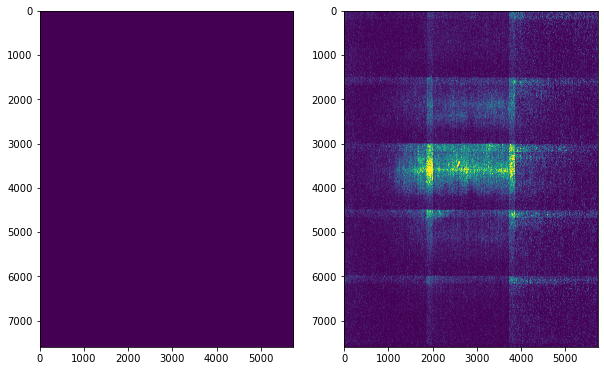

In [18]:
z=100
raw_atlas_im = tifffile.imread(raw_atlas_files[z])
raw_im = tifffile.imread(raw_files[z])
fig = plt.figure(figsize=(10,8))
ax_atlas=fig.add_subplot(121)
ax_atlas.imshow(raw_atlas_im,vmin=0,vmax=2000)
ax_data=fig.add_subplot(122)
ax_data.imshow(raw_im,vmin=0,vmax=1)